In [2]:
# Cell 1: Install & import, plus lemmatization setup
!pip install nltk wordcloud

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
import re
from sklearn.datasets import fetch_20newsgroups

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens if len(tok)>2]
    return ' '.join(lemmas)

# Load and preprocess
ng = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))
raw_docs, y, names = ng.data, ng.target, ng.target_names

# This may take ~1–2 min
docs = [preprocess_and_lemmatize(doc) for doc in raw_docs]
print(f"Prepared {len(docs)} documents.")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Prepared 18846 documents.


In [3]:
# Cell 2: Vectorize and split
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.8,
    min_df=3,
    max_features=3000,
    ngram_range=(1,2)
)
X = vectorizer.fit_transform(docs)
print("TF-IDF shape:", X.shape)

# 80/20 split
split = int(X.shape[0] * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


TF-IDF shape: (18846, 3000)


In [4]:
# Cell 3: Fit Multinomial Naïve Bayes and print metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report

clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:      ", accuracy_score(y_test, y_pred))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 (macro):     ", f1_score(y_test, y_pred, average='macro'))
print("\nFull classification report:\n")
print(classification_report(y_test, y_pred, target_names=names))


Accuracy:       0.6694960212201592
Recall (macro): 0.6570058375686726
F1 (macro):      0.6530204062565023

Full classification report:

                          precision    recall  f1-score   support

             alt.atheism       0.62      0.49      0.55       175
           comp.graphics       0.59      0.61      0.60       199
 comp.os.ms-windows.misc       0.67      0.58      0.62       221
comp.sys.ibm.pc.hardware       0.56      0.64      0.60       179
   comp.sys.mac.hardware       0.65      0.62      0.63       177
          comp.windows.x       0.72      0.82      0.76       179
            misc.forsale       0.77      0.70      0.73       205
               rec.autos       0.71      0.60      0.65       228
         rec.motorcycles       0.44      0.73      0.55       183
      rec.sport.baseball       0.72      0.78      0.75       197
        rec.sport.hockey       0.82      0.84      0.83       204
               sci.crypt       0.81      0.72      0.77       218
     

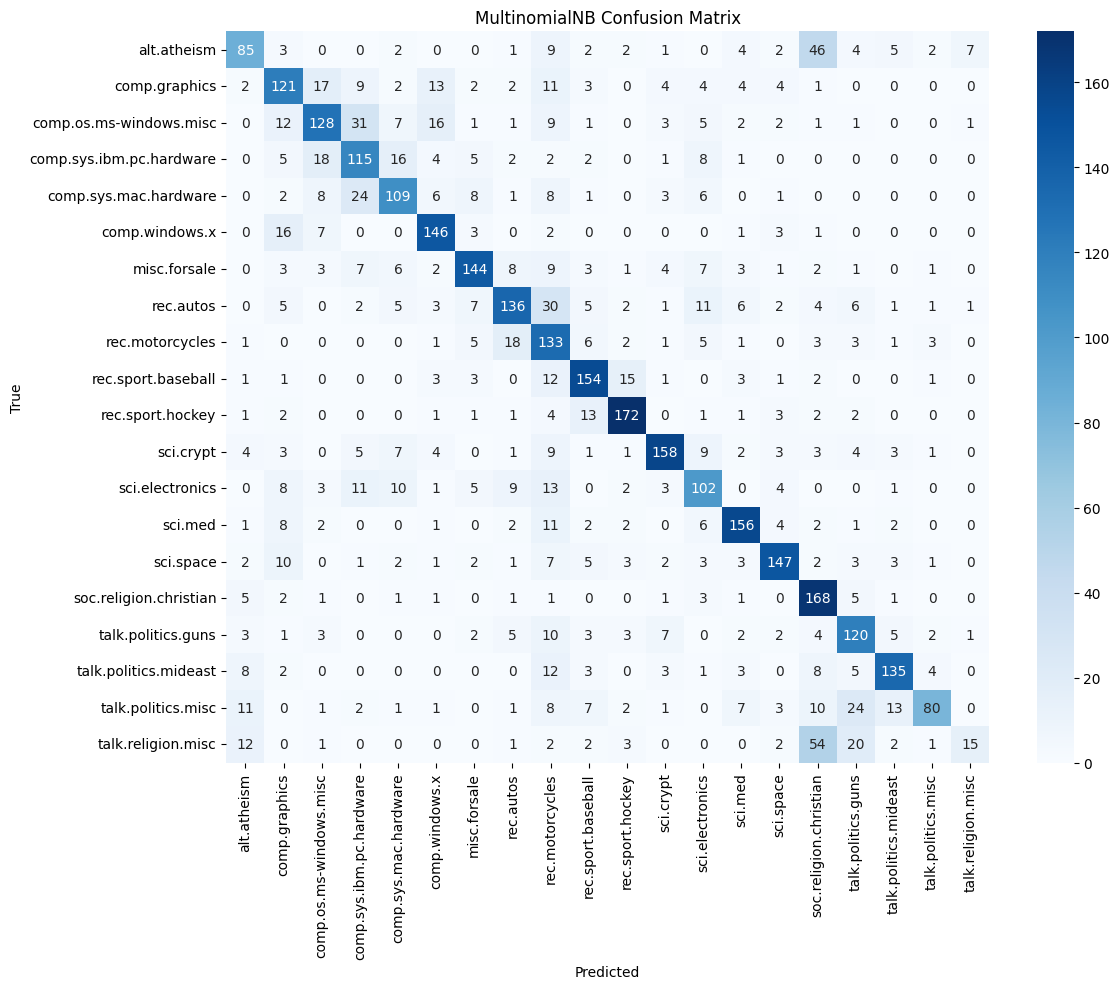

In [5]:
# Cell 4: Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=names, yticklabels=names)
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("MultinomialNB Confusion Matrix")
plt.tight_layout()
plt.show()


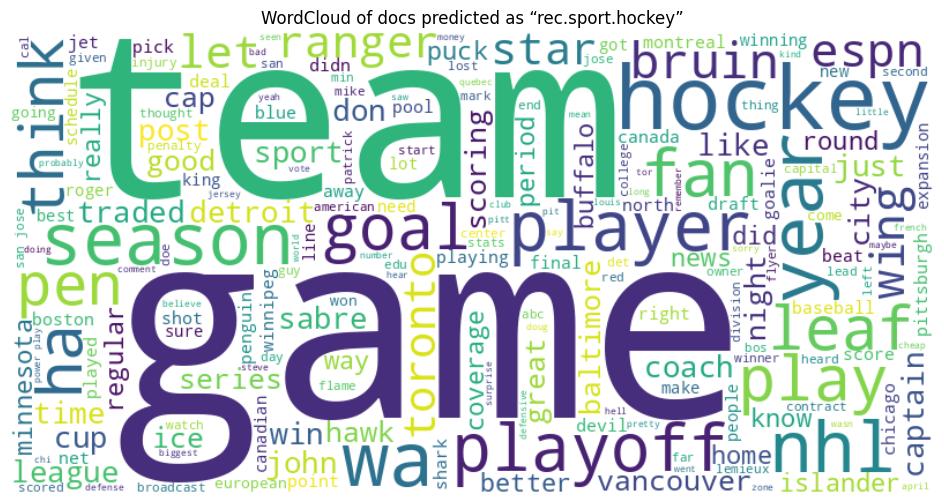

In [10]:
# Cell 5: WordCloud for one predicted class (e.g. class 0)
import numpy as np
from wordcloud import WordCloud

target_class = 10  # change 0–19 to view different classes
idxs = np.where(y_pred == target_class)[0]
# If too many, you can sample: idxs = np.random.choice(idxs, 2000, replace=False)

# Sum TF-IDF scores for that class
tfidf_sum = X_test[idxs].toarray().sum(axis=0)
terms = vectorizer.get_feature_names_out()
freqs = {terms[i]: tfidf_sum[i] for i in np.argsort(tfidf_sum)[-200:]}  # top-200

wc = WordCloud(
    width=800, height=400,
    background_color='white'
).generate_from_frequencies(freqs)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"WordCloud of docs predicted as “{names[target_class]}”")
plt.show()
